버스 정류장 도착 시간 예측

## 프로젝트 목적 



증가하는 제주도 상주인구로 인한 교통난을 해결하고 효율적인 버스 운행을 위해 운행 시간을 예측하는 모델 개발
예측성능을 높이기 위해 xgboost 사용하고 
K-fold를 이용하여 K-validation을 수행합니다.


## 미니 프로젝트 목적
해당 날짜 별, 노선 및 버스 ID가 주어진 상황에서 현재 정류소의 이름과 현재 정류장 도착 시간을 이용하여,

다음 정류장에 도착할 때까지 걸리는 시간을 예측하기 위한 데이터를 제공해 드립니다

In [112]:
import numpy as np # 행렬 연산 / 데이터 핸들링
import pandas as pd # 데이터 분석
import matplotlib.pyplot as plt # 그래프 시각화
import seaborn as sns # 그래프 시각화
from xgboost import XGBRegressor # XGBoost Regressor 모델
from sklearn.model_selection import KFold # K-validation
from sklearn.metrics import accuracy_score # 정확도 측정 함수
from sklearn.preprocessing import LabelEncoder # 라벨 인코더

## 데이터 설명 

In [113]:
# 해당 날짜 별, 노선과 버스 ID가 주어지고 
# 현재 정류장의 이름과 도착시간을 이용하여 다음 정류장에 도착할 때까지 걸리는 시간을 예측

### 학습 / 테스트 데이터 

In [114]:
bus_te = pd.read_csv('test.csv', sep=',')
bus_tr = pd.read_csv('train.csv', sep=',')

In [115]:
bus_tr

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time
0,0,2019-10-15,405136001,7997025,360-1,33.456267,126.551750,제주대학교입구,06시,266.0,제대마을,33.457724,126.554014,24
1,1,2019-10-15,405136001,7997025,360-1,33.457724,126.554014,제대마을,06시,333.0,제대아파트,33.458783,126.557353,36
2,2,2019-10-15,405136001,7997025,360-1,33.458783,126.557353,제대아파트,06시,415.0,제주대학교,33.459893,126.561624,40
3,3,2019-10-15,405136001,7997025,360-1,33.479705,126.543811,남국원(아라방면),06시,578.0,제주여자중고등학교(아라방면),33.484860,126.542928,42
4,4,2019-10-15,405136001,7997025,360-1,33.485662,126.494923,도호동,07시,374.0,은남동,33.485822,126.490897,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210452,210452,2019-10-28,405328102,7983486,281-2,33.255783,126.577450,비석거리,21시,528.0,삼아아파트,33.251896,126.574417,96
210453,210453,2019-10-28,405328102,7983486,281-2,33.248595,126.568527,동문로터리,21시,280.0,매일올레시장 7번입구,33.249753,126.565959,50
210454,210454,2019-10-28,405328102,7983486,281-2,33.251891,126.560303,서귀포시 구 버스터미널,21시,114.0,아랑조을거리 입구,33.251084,126.559551,16
210455,210455,2019-10-28,405328102,7983486,281-2,33.251084,126.559551,아랑조을거리 입구,21시,223.0,평생학습관,33.249504,126.558068,38


In [116]:
bus_te

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude
0,210457,2019-10-29,405136001,7997025,360-1,33.457724,126.554014,제대마을,07시,333.0,제대아파트,33.458783,126.557353
1,210458,2019-10-29,405136001,7997025,360-1,33.458783,126.557353,제대아파트,07시,415.0,제주대학교,33.459893,126.561624
2,210459,2019-10-29,405136001,7997025,360-1,33.478867,126.483833,한라중학교/부영아파트,08시,417.0,대림2차아파트,33.478850,126.488350
3,210460,2019-10-29,405136001,7997025,360-1,33.478850,126.488350,대림2차아파트,08시,334.0,연동대림1차아파트,33.480700,126.489933
4,210461,2019-10-29,405136001,7997025,360-1,33.480700,126.489933,연동대림1차아파트,08시,550.0,케이티앤지,33.482077,126.485355
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91769,302350,2019-11-05,405328102,7983486,281-2,33.493625,126.534764,제주지방법원(광양방면),20시,272.0,고산동산(광양방면),33.495540,126.532907
91770,302351,2019-11-05,405328102,7983486,281-2,33.495540,126.532907,고산동산(광양방면),20시,447.0,제주시청(광양방면),33.498925,126.530351
91771,302352,2019-11-05,405328102,7983486,281-2,33.498925,126.530351,제주시청(광양방면),20시,418.0,광양사거리,33.500473,126.527103
91772,302353,2019-11-05,405328102,7983486,281-2,33.500473,126.527103,광양사거리,20시,140.0,탐라장애인 종합복지관,33.500228,126.525625


In [117]:
bus_tr.shape, bus_te.shape

((210457, 14), (91774, 13))

In [118]:
bus_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210457 entries, 0 to 210456
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                210457 non-null  int64  
 1   date              210457 non-null  object 
 2   route_id          210457 non-null  int64  
 3   vh_id             210457 non-null  int64  
 4   route_nm          210457 non-null  object 
 5   now_latitude      210457 non-null  float64
 6   now_longitude     210457 non-null  float64
 7   now_station       210457 non-null  object 
 8   now_arrive_time   210457 non-null  object 
 9   distance          210457 non-null  float64
 10  next_station      210457 non-null  object 
 11  next_latitude     210457 non-null  float64
 12  next_longitude    210457 non-null  float64
 13  next_arrive_time  210457 non-null  int64  
dtypes: float64(5), int64(4), object(5)
memory usage: 22.5+ MB


In [70]:
bus_tr.isna().sum()

id                  0
date                0
route_id            0
vh_id               0
route_nm            0
now_latitude        0
now_longitude       0
now_station         0
now_arrive_time     0
distance            0
next_station        0
next_latitude       0
next_longitude      0
next_arrive_time    0
dtype: int64

In [71]:
bus_te.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91774 entries, 0 to 91773
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               91774 non-null  int64  
 1   date             91774 non-null  object 
 2   route_id         91774 non-null  int64  
 3   vh_id            91774 non-null  int64  
 4   route_nm         91774 non-null  object 
 5   now_latitude     91774 non-null  float64
 6   now_longitude    91774 non-null  float64
 7   now_station      91774 non-null  object 
 8   now_arrive_time  91774 non-null  object 
 9   distance         91774 non-null  float64
 10  next_station     91774 non-null  object 
 11  next_latitude    91774 non-null  float64
 12  next_longitude   91774 non-null  float64
dtypes: float64(5), int64(3), object(5)
memory usage: 9.1+ MB


In [72]:
bus_te.isna().sum()

id                 0
date               0
route_id           0
vh_id              0
route_nm           0
now_latitude       0
now_longitude      0
now_station        0
now_arrive_time    0
distance           0
next_station       0
next_latitude      0
next_longitude     0
dtype: int64

## 데이터 전처리 

#### 정류장 이름 인코딩

In [119]:
station = list(bus_tr['now_station'].values) + list(bus_tr['next_station'].values) # train 의 모든 정류장 이름
station_set = set(station)
print(len(station_set))

351


In [120]:
station_encoder = LabelEncoder()        # 인코더 생성
station_encoder.fit(list(station_set))  # 인코딩 

# train 정류장 치환
bus_tr['now_station'] = station_encoder.transform(bus_tr['now_station'])
bus_tr['next_station'] = station_encoder.transform(bus_tr['next_station'])

# test 정류장 치환 
bus_te['now_station'] = station_encoder.transform(bus_te['now_station'])
bus_te['next_station'] = station_encoder.transform(bus_te['next_station'])
bus_tr.head()

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time
0,0,2019-10-15,405136001,7997025,360-1,33.456267,126.551750,239,06시,266.0,227,33.457724,126.554014,24
1,1,2019-10-15,405136001,7997025,360-1,33.457724,126.554014,227,06시,333.0,228,33.458783,126.557353,36
2,2,2019-10-15,405136001,7997025,360-1,33.458783,126.557353,228,06시,415.0,235,33.459893,126.561624,40
3,3,2019-10-15,405136001,7997025,360-1,33.479705,126.543811,41,06시,578.0,249,33.484860,126.542928,42
4,4,2019-10-15,405136001,7997025,360-1,33.485662,126.494923,63,07시,374.0,221,33.485822,126.490897,64


#### 필요없는 featuere 제거

In [121]:
# train

bus_tr = bus_tr.drop(['id', 'route_nm', 'next_latitude', 'next_longitude', 
                              'now_latitude', 'now_longitude'], axis=1)
bus_tr.head()

,date,route_id,vh_id,now_station,now_arrive_time,distance,next_station,next_arrive_time
0,2019-10-15,405136001,7997025,239,06시,266.0,227,24
1,2019-10-15,405136001,7997025,227,06시,333.0,228,36
2,2019-10-15,405136001,7997025,228,06시,415.0,235,40
3,2019-10-15,405136001,7997025,41,06시,578.0,249,42
4,2019-10-15,405136001,7997025,63,07시,374.0,221,64


In [122]:
# test
bus_te = bus_te.drop(['route_nm', 'next_latitude', 'next_longitude', 
                              'now_latitude', 'now_longitude'], axis=1)
bus_te.head()

,id,date,route_id,vh_id,now_station,now_arrive_time,distance,next_station
0,210457,2019-10-29,405136001,7997025,227,07시,333.0,228
1,210458,2019-10-29,405136001,7997025,228,07시,415.0,235
2,210459,2019-10-29,405136001,7997025,323,08시,417.0,59
3,210460,2019-10-29,405136001,7997025,59,08시,334.0,183
4,210461,2019-10-29,405136001,7997025,183,08시,550.0,285


#### 날짜 -> 요일(평일 / 주말)

In [123]:
# train 
# 2019.10.15 ~ 10.29 공휴일 없음

bus_tr['date'] = pd.to_datetime(bus_tr['date']) # date 값을 datetime으로
bus_tr['weekday'] = bus_tr['date'].dt.weekday  # Monday 0 ~ Sunday 6 
bus_tr = bus_tr.drop('date', axis=1) # 필요없는 date 칼럼을 drop
bus_tr.head()

,route_id,vh_id,now_station,now_arrive_time,distance,next_station,next_arrive_time,weekday
0,405136001,7997025,239,06시,266.0,227,24,1
1,405136001,7997025,227,06시,333.0,228,36,1
2,405136001,7997025,228,06시,415.0,235,40,1
3,405136001,7997025,41,06시,578.0,249,42,1
4,405136001,7997025,63,07시,374.0,221,64,1


In [78]:
bus_tr['weekday'].unique()

array([1, 2, 3, 4, 5, 6, 0], dtype=int64)

In [124]:
# test

bus_te['date'] = pd.to_datetime(bus_te['date'])
bus_te['weekday'] = bus_te['date'].dt.weekday 
bus_te = bus_te.drop('date', axis=1)
bus_te.head()

,id,route_id,vh_id,now_station,now_arrive_time,distance,next_station,weekday
0,210457,405136001,7997025,227,07시,333.0,228,1
1,210458,405136001,7997025,228,07시,415.0,235,1
2,210459,405136001,7997025,323,08시,417.0,59,1
3,210460,405136001,7997025,59,08시,334.0,183,1
4,210461,405136001,7997025,183,08시,550.0,285,1


#### now_arrive_time -> 시간대별로 나눠주기

In [80]:
np.sort(bus_tr['now_arrive_time'].unique())
# 01시 ~ 04시의 데이터가 존재하지 않는다

array(['00시', '05시', '06시', '07시', '08시', '09시', '10시', '11시', '12시',
       '13시', '14시', '15시', '16시', '17시', '18시', '19시', '20시', '21시',
       '22시', '23시'], dtype=object)

C:\Users\ICT01_04\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ICT01_04\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0, flags=flags)


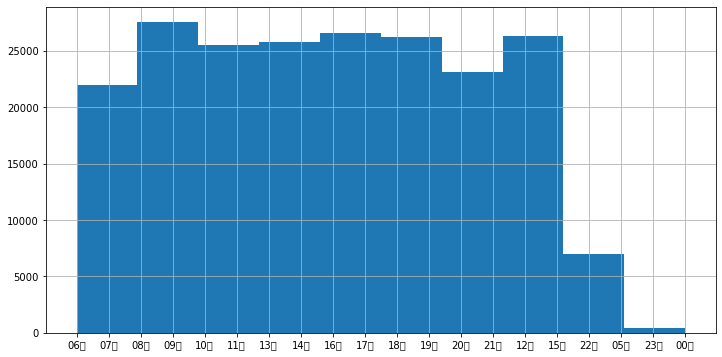

In [81]:
time = bus_tr['now_arrive_time']

plt.figure(figsize=(12,6))
plt.hist(time)
plt.grid(True)
plt.show()

## 시각화

- 각 요일별, 시간대별 타겟 평균

C:\Users\ICT01_04\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ICT01_04\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0, flags=flags)


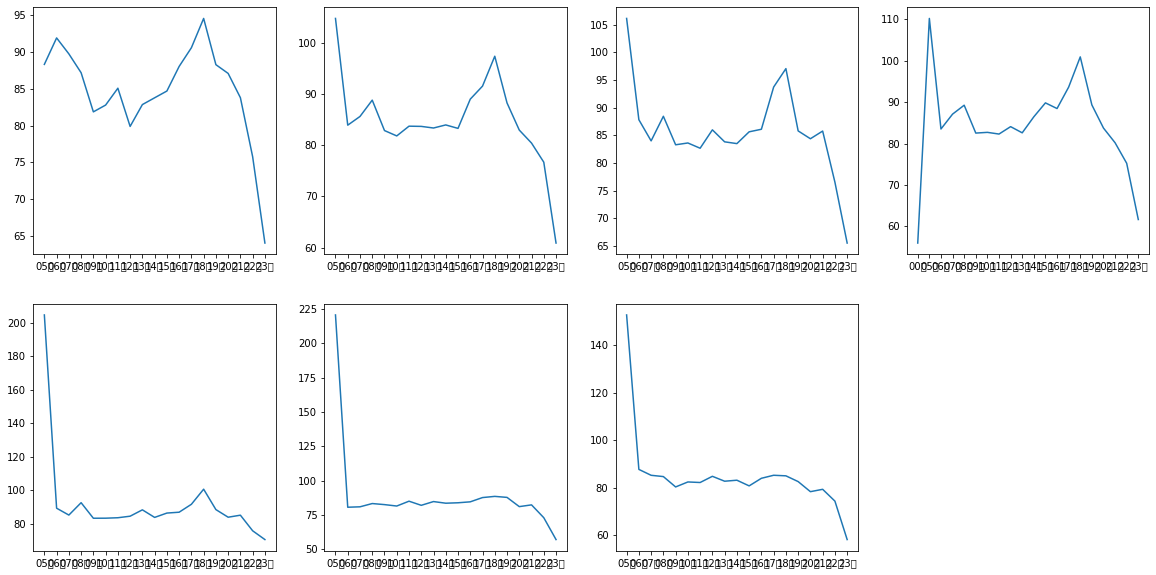

In [159]:
plt.figure(figsize=(20,10))
for i in range(7):
    plt.subplot(2,4,i+1)
    plt.plot(bus_tr.groupby('weekday').get_group(i).groupby('now_arrive_time').mean()['next_arrive_time'])

C:\Users\ICT01_04\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ICT01_04\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0, flags=flags)


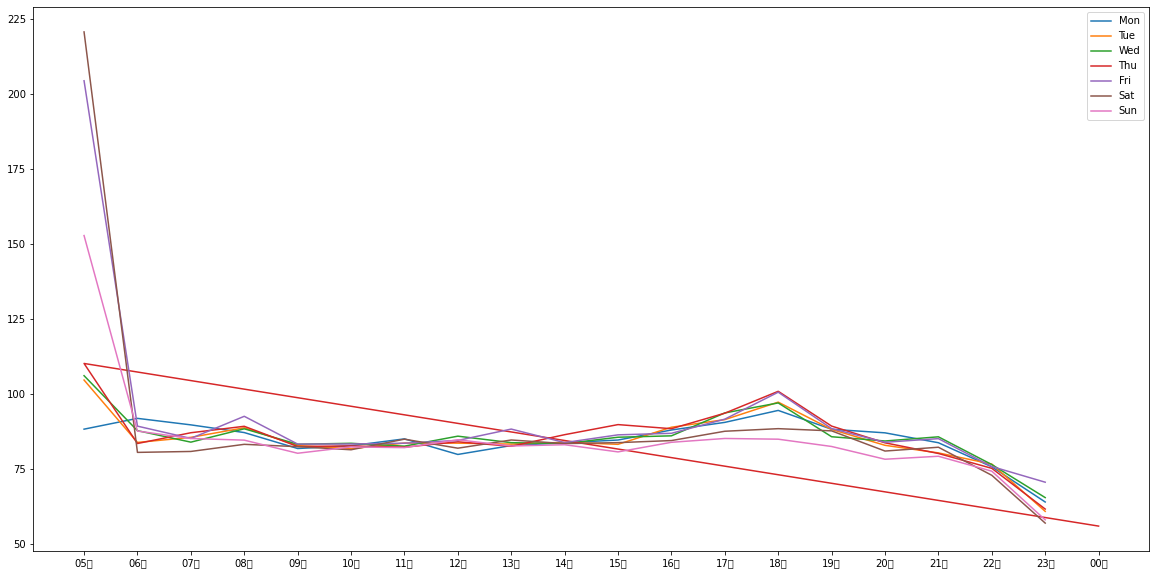

In [162]:
plt.figure(figsize=(20,10))
for i in range(7):
    plt.plot(bus_tr.groupby('weekday').get_group(i).groupby('now_arrive_time').mean()['next_arrive_time'])
plt.legend(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

In [164]:
bus_tr.groupby('weekday').get_group(3).groupby('now_arrive_time').mean()['next_arrive_time']

now_arrive_time
00시     56.000000
05시    110.235294
06시     83.538345
07시     87.130985
08시     89.281731
09시     82.554931
10시     82.729156
11시     82.318777
12시     84.108394
13시     82.615222
14시     86.484917
15시     89.846779
16시     88.478303
17시     93.652582
18시    100.949079
19시     89.351006
20시     83.769026
21시     80.215422
22시     75.258560
23시     61.682540
Name: next_arrive_time, dtype: float64

- 목요일에만 00시 데이터가 존재
- 토, 금, 일요일 5시대 시간 높음
- 월요일 5시대는 낮음
- 18시대는 전부 높은 양상

In [166]:
bus_tr.groupby('weekday').get_group(3)

,route_id,vh_id,now_station,now_arrive_time,distance,next_station,next_arrive_time,weekday
0,405136001,7997025,239,06시,266.0,227,24,1
1,405136001,7997025,227,06시,333.0,228,36,1
2,405136001,7997025,228,06시,415.0,235,40,1
3,405136001,7997025,41,06시,578.0,249,42,1
4,405136001,7997025,63,07시,374.0,221,64,1
...,...,...,...,...,...,...,...,...
210452,405328102,7983486,95,21시,528.0,108,96,0
210453,405328102,7983486,65,21시,280.0,81,50,0
210454,405328102,7983486,122,21시,114.0,178,16,0
210455,405328102,7983486,178,21시,223.0,298,38,0


In [134]:
# 노선
bus_tr.groupby('vh_id').get_group(7997025).groupby('now_arrive_time').mean()['next_arrive_time']

now_arrive_time
06시     92.396947
07시     91.676647
08시     85.983607
09시     93.056180
10시     89.064748
11시     88.163636
12시     93.510490
13시     91.523810
14시     86.341880
15시     91.162393
16시     92.102564
17시     96.890511
18시    103.156863
19시     96.313953
20시     87.790210
21시     94.045977
22시     81.121212
Name: next_arrive_time, dtype: float64